In [3]:
#pip install qiskit

In [4]:
#pip install qiskit[visualization]

In this notebook we execute the quantum circuit of a search algorithm based on Discrete-Time Quanutm Walks (DTQW).

# Circuit execution

In [5]:
#Importing libraries
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.circuit.library import MCMT
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [6]:
#Enter target node
target=1
#Input the number of bits for the binary representation of the target node
number_bits=2
binary_target=bin(target)[2:].zfill(number_bits)

In [7]:
#Setting the number of qubits of the position and coin registers
pos_reg = number_bits
coin_reg= number_bits

#Creating quantum and classical registers
creg = qiskit.ClassicalRegister(pos_reg+coin_reg, 'c')
qreg = qiskit.QuantumRegister(pos_reg+coin_reg, 'q')

#Circuit definition
circuit1 = qiskit.QuantumCircuit(qreg,creg)

In [8]:
#Initializing the coin register as the target state
for i in reversed(range(number_bits)):
  if binary_target[i] == '1':
    circuit1.x(2*number_bits-(i+1))

#Applying the Hadamard gate to the whole register
for i in range(pos_reg+coin_reg):
  circuit1.h(i)

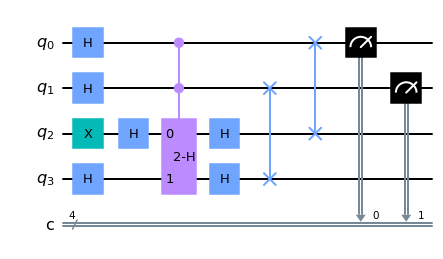

In [9]:
#Defining the number of steps the walker will take
steps=1

#Building of the perturbed operator
for i in range(steps):
 
  circuit2=MCMT('h', num_ctrl_qubits=pos_reg, num_target_qubits=coin_reg)
  
  circuit=circuit1.compose(circuit2, qubits=list(range(pos_reg+coin_reg)))

  
  for i in range(coin_reg):
    circuit.h(pos_reg+i)

  for i in reversed(range(pos_reg)):
    circuit.swap(pos_reg+i, i) #Uncomment to perform search
    #circuit.cnot(pos_reg+i, i) #Uncomment to perform search complement

#Measuring position register
for i in range(pos_reg):
   circuit.measure(i,i)
  
circuit.draw('mpl')

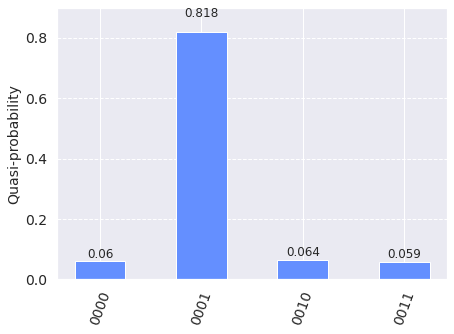

<Figure size 1224x1080 with 0 Axes>

In [10]:
#Setting the simulator
sim = qiskit.Aer.get_backend('qasm_simulator')

#job execution and getting the result as an object
job = execute(circuit, sim,shots=8192)

#Transforming results to probabilities
counts=job.result().get_counts()
factor=1.0/sum(counts.values())
probabilities = {k: v*factor for k, v in counts.items()}
#probabilities=counts

#Plotting state probabilities histogram
plt.figure(figsize=(17, 15))
qiskit.visualization.plot_histogram(probabilities)

# *Matrix Representation*

In [11]:
#Remove measurement gates
for i in range(pos_reg):
  if circuit.data[-1][0].name == 'measure' :
    circuit.data.pop(-1)

In [12]:
backend = Aer.get_backend('unitary_simulator')
result = execute(circuit, backend, shots=8192).result()
u_matrix=result.get_unitary(circuit,3).data

**Unitar matrix**

This is the unitary matrix representation of the circuit used to perform the search algorithm.

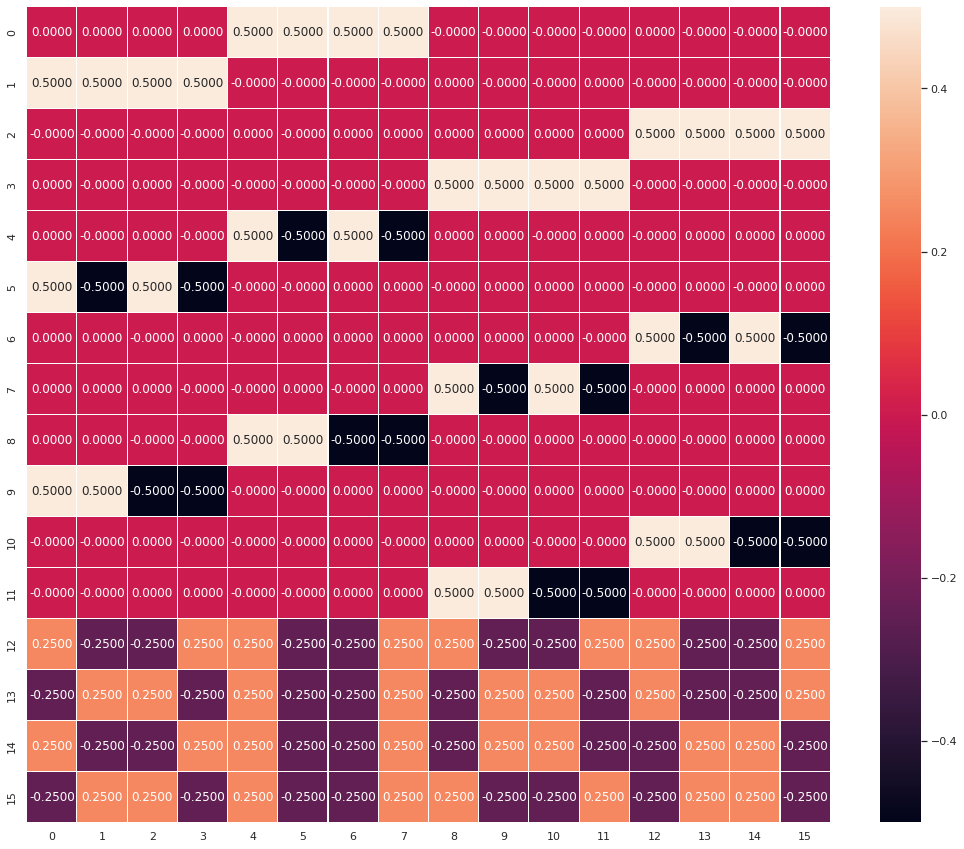

In [13]:
plt.figure(figsize=(18, 15))
#ax = sns.heatmap(np.real(u_matrix).T, annot=True, linewidths=0.1, fmt='.4f')#, cmap=ListedColormap(['white']))
ax = sns.heatmap(np.real(u_matrix), annot=True, linewidths=0.1, fmt='.4f')#, cmap=ListedColormap(['white']))

**Probability matrix**

This matrix is obtained directly from the matrix form of the evolution operator of a quantum walk. It contains the probability distributions associated to the quantum state of a walker. E.g. if the state of the walker is $|\psi_0\rangle=|2\rangle|1\rangle$ transforming labels to binary notation we get $|\psi_0\rangle=|10\rangle|01\rangle \implies |\psi_0\rangle=|1001\rangle$. The string $1001$ in binary equals $9$ in decimal notation. Thus, the 9th column of the probability matrix contains the probability distribution of the DTQW when the initial state of the quantum walker is $|\psi_0\rangle=|2\rangle|1\rangle$.

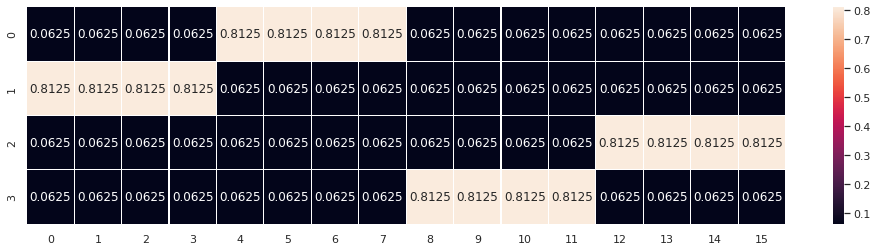

In [14]:
n=2**pos_reg

M=np.zeros((n,n*m))

plt.figure(figsize=(17, 4))
for i in range(m):
  M=M+np.multiply(np.conjugate(u_matrix[i*n:(i+1)*n,:]), u_matrix[i*n:(i+1)*n,:])

ax = sns.heatmap(np.real(M), annot=True, linewidths=0.1, fmt='.4f')#, cmap=ListedColormap(['white']))
